In [1]:
import pandas as pd
import ast
import os
from pathlib import Path
from typing import List, Dict
import numpy as np

In [2]:
# Read patient data with from csv file
def read_data(
    path: Path,
    initial_evidence: str
) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df['INITIAL_EVIDENCE'] == initial_evidence]    

    return df

In [3]:
def preprocess_data(
    df: pd.DataFrame
) -> pd.DataFrame:
    # Convert string to list
    df['EVIDENCES'] = df['EVIDENCES'].apply(ast.literal_eval)
    df['DIFFERENTIAL_DIAGNOSIS'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)
    df['DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(lambda x: [ddx[0] for ddx in x])

    return df

In [4]:
df = read_data('../ddxplus/raw-data/release_test_patients.csv', 'toux')
df = preprocess_data(df)

df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB
0,49,"[[Bronchite, 0.20230062181160519], [RGO, 0.179...",F,RGO,"[douleurxx, douleurxx_carac_@_lancinante_/_cho...",toux,"[Bronchite, RGO, Possible NSTEMI / STEMI, Angi..."
4,70,"[[IVRS ou virémie, 0.21257615919851483], [Poss...",F,IVRS ou virémie,"[contact, diaph, douleurxx, douleurxx_carac_@_...",toux,"[IVRS ou virémie, Possible influenza ou syndro..."
22,10,[[Possible influenza ou syndrome virémique typ...,F,Possible influenza ou syndrome virémique typique,"[diaph, douleurxx, douleurxx_carac_@_une_lourd...",toux,[Possible influenza ou syndrome virémique typi...
26,1,"[[Bronchite, 0.29070421508775757], [Otite moye...",M,Otite moyenne aigue (OMA),"[H6690, douleurxx, douleurxx_carac_@_sensible,...",toux,"[Bronchite, Otite moyenne aigue (OMA), Pneumon..."
52,77,"[[IVRS ou virémie, 0.24961180257533938], [Bron...",M,IVRS ou virémie,"[crowd, douleurxx, douleurxx_carac_@_pénible, ...",toux,"[IVRS ou virémie, Bronchite, Possible influenz..."


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-848x35nh because the default path (/home/wlchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


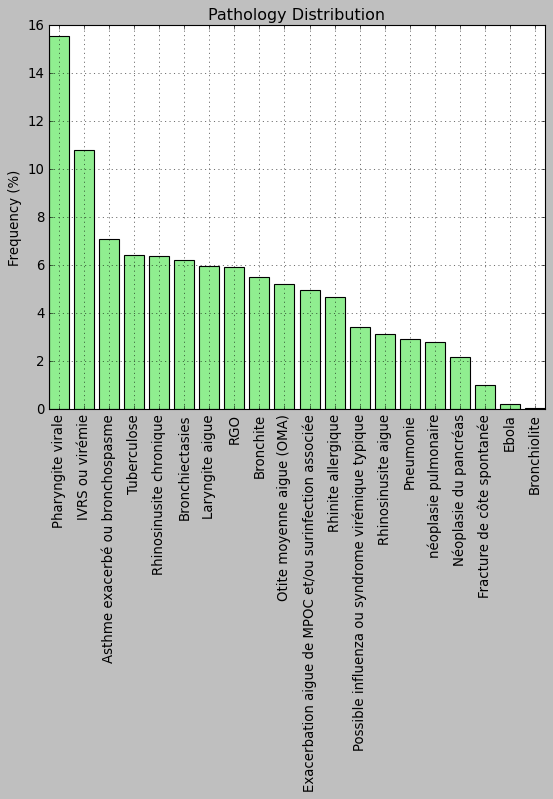

In [5]:
import matplotlib.pyplot as plt

# plot PATHOLOGY distribution
plt.style.use('classic')
plt.bar(
    df['PATHOLOGY'].value_counts().index,
    df['PATHOLOGY'].value_counts() / df['PATHOLOGY'].value_counts().sum() * 100,
    color='lightgreen'
)
plt.xticks(rotation=90)
plt.ylabel('Frequency (%)')
plt.title('Pathology Distribution')
plt.grid(True)
plt.show()

In [6]:
from collections import Counter

def plot_feature_distribution_for_each_pathology(
    df: pd.DataFrame,
    feature: str,
    top_n: int = 50
):
    gb = df.groupby('PATHOLOGY')
    plt.style.use('classic')
    fig, axs = plt.subplots(
        nrows=len(gb.groups.keys()),
        ncols=1,
        sharey=True,
        figsize=(5, 125)
    )
    fig.subplots_adjust(top=0.8, hspace=3)
    # fig.autofmt_xdate(rotation=90)

    for ax, pathology in zip(axs, gb.groups.keys()):
        evidence_set = Counter()
        gb.get_group(pathology)[feature].apply(lambda x: evidence_set.update({evidence: 1 for evidence in x}))
        top_n = min(top_n, len(evidence_set))

        # plot evidence distribution
        ax.bar(
            [k for k, v in evidence_set.most_common(top_n)],
            np.array([v for k, v in evidence_set.most_common(top_n)]) / sum(evidence_set.values()) * 100,
            color='lightgreen'
        )

        ax.set_title(pathology, fontsize=10)
        ax.tick_params('x', labelrotation=90, labelsize=8)
        ax.tick_params('y', labelsize=8)
        ax.yaxis.grid(True)
    plt.show()

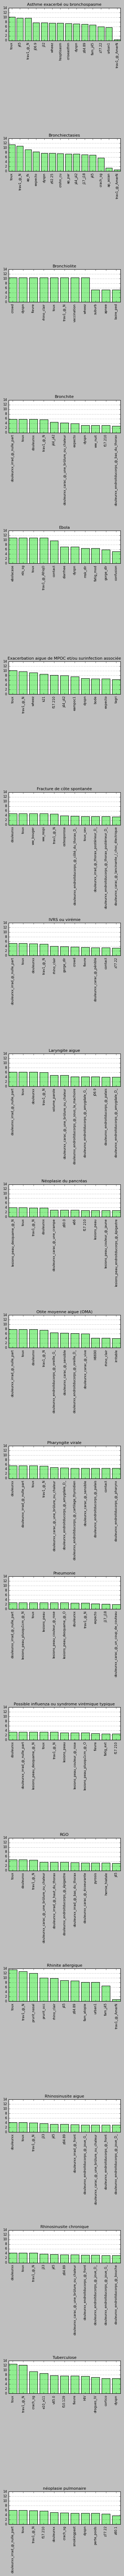

In [7]:
plot_feature_distribution_for_each_pathology(df, feature='EVIDENCES')

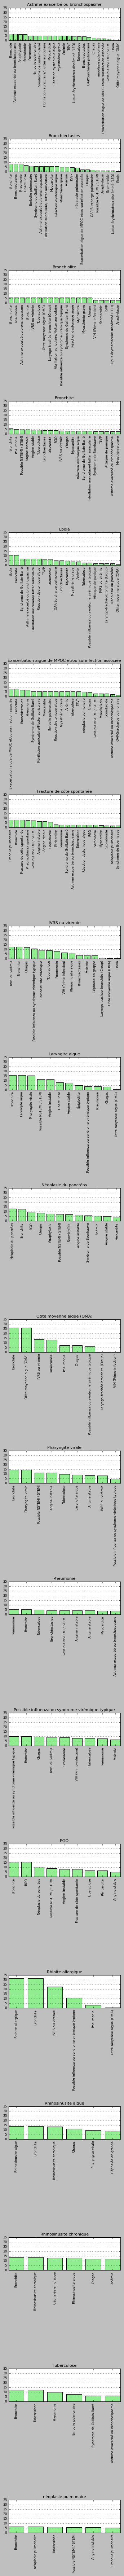

In [8]:
plot_feature_distribution_for_each_pathology(df, feature='DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB')

In [31]:
# Generate eda report
# 
# There are threee main section:
#   1. Overview: Basic statistial information of the dataset
#   2. Variables: Detailed statistial information of each variable (i.e., column)
#   3. Interactions: In this section you can plot one variable against another for observing relatedness.
#   4. Coorelations: Observe correlatioon between variables.
#
# [ref] https://towardsdatascience.com/pandas-profiling-easy-exploratory-data-analysis-in-python-65d6d0e23650

# from pandas_profiling import ProfileReport
# report = ProfileReport(patient_testing_set_toux)
# report